In [26]:
import os
import re
import string
import pickle
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [27]:

df = pd.read_csv('data1.csv')
print("Initial dataset shape:", df.shape)
assert 'Review Text' in df.columns, "Column 'Review Text' not found in data1.csv"

df = df.drop_duplicates(subset=['Review Text']).reset_index(drop=True)
print("After removing duplicates:", df.shape)


Initial dataset shape: (5000, 3)
After removing duplicates: (4052, 3)


In [28]:

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_text'] = df['Review Text'].apply(clean_text)

min_length = 2
max_length = 100
df['word_count'] = df['cleaned_text'].str.split().str.len()
original_count = len(df)

df = df[(df['word_count'] >= min_length) & (df['word_count'] <= max_length)].copy()
filtered_count = original_count - len(df)
print(f"Filtered out {filtered_count} rows by length constraints [{min_length}, {max_length}]")

def expand_short_review(text, word_count):
    if word_count <= 5:
        if any(w in text for w in ['good', 'great', 'nice', 'love']):
            return text + " overall satisfied with product"
        elif any(w in text for w in ['bad', 'poor', 'worst']):
            return text + " very disappointed with quality"
        else:
            return text + " average product experience"
    return text

df['processed_text'] = df.apply(lambda r: expand_short_review(r['cleaned_text'], r['word_count']), axis=1)
df['final_word_count'] = df['processed_text'].str.split().str.len()


Filtered out 0 rows by length constraints [2, 100]


In [29]:

def detect_sentiment(reviews):
    positive_words = {'good', 'great', 'excellent', 'amazing', 'perfect', 'outstanding',
                      'fantastic', 'wonderful', 'superb', 'awesome', 'love', 'best', 'nice', 'recommend'}
    negative_words = {'bad', 'poor', 'worst', 'terrible', 'horrible', 'awful',
                      'disappointing', 'useless', 'waste', 'hate', 'issue', 'problem', 'broken'}
    sentiments = []
    for review in reviews:
        words = set(str(review).lower().split())
        pos_count = len(words & positive_words)
        neg_count = len(words & negative_words)
        if pos_count > neg_count:
            sentiments.append('positive')
        elif neg_count > pos_count:
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    return sentiments

df['sentiment'] = detect_sentiment(df['Review Text'].tolist())

print("\nSentiment distribution (heuristic):")
print(df['sentiment'].value_counts())



Sentiment distribution (heuristic):
sentiment
neutral     3593
positive     459
Name: count, dtype: int64


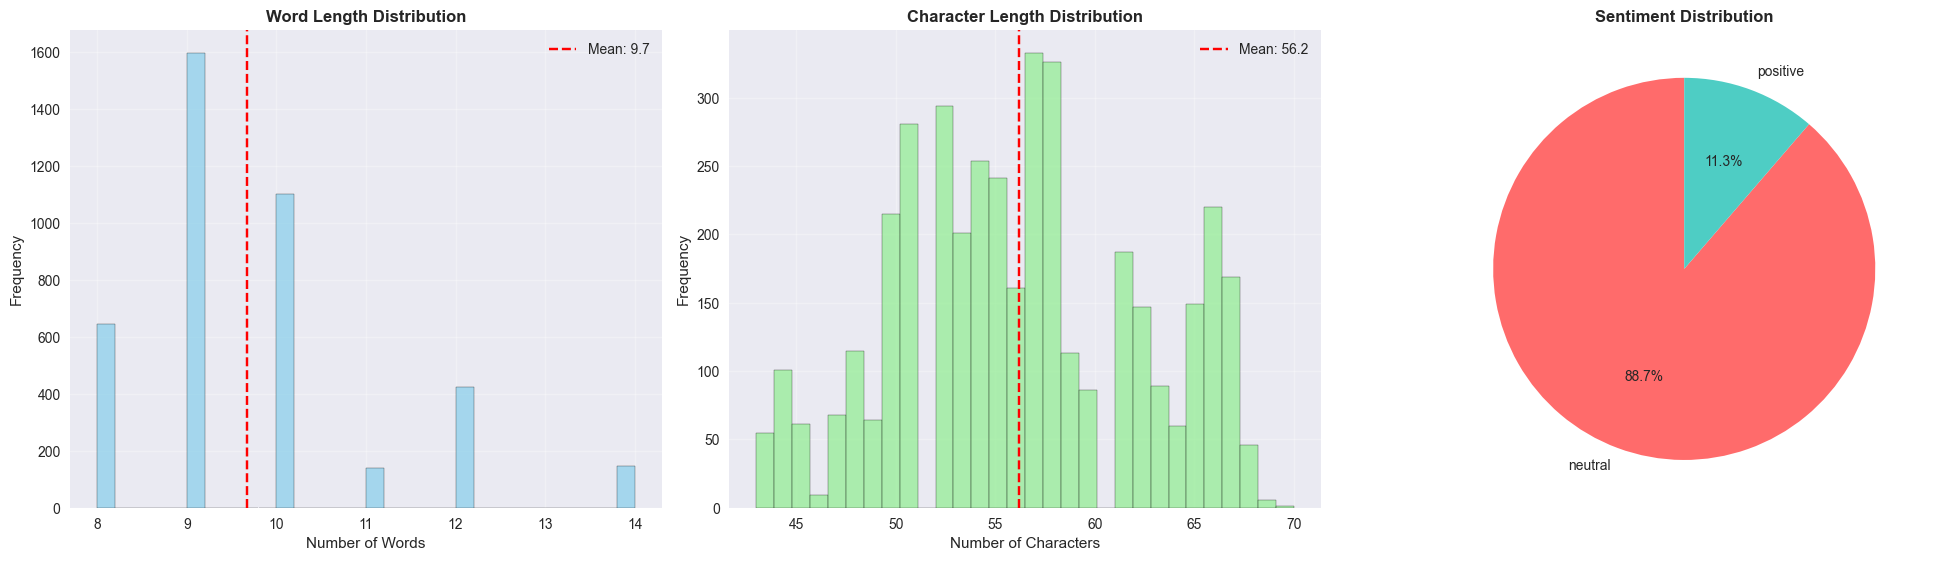

In [30]:

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_text_analysis(dataframe):
    fig = plt.figure(figsize=(20, 16))

    plt.subplot(3, 3, 1)
    word_lengths = dataframe['cleaned_text'].str.split().str.len()
    plt.hist(word_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(word_lengths.mean(), color='red', linestyle='--', label=f'Mean: {word_lengths.mean():.1f}')
    plt.title('Word Length Distribution', fontweight='bold')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 2)
    char_lengths = dataframe['cleaned_text'].str.len()
    plt.hist(char_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(char_lengths.mean(), color='red', linestyle='--', label=f'Mean: {char_lengths.mean():.1f}')
    plt.title('Character Length Distribution', fontweight='bold')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 3)
    sentiment_counts = dataframe['sentiment'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
    plt.title('Sentiment Distribution', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_text_analysis(df)


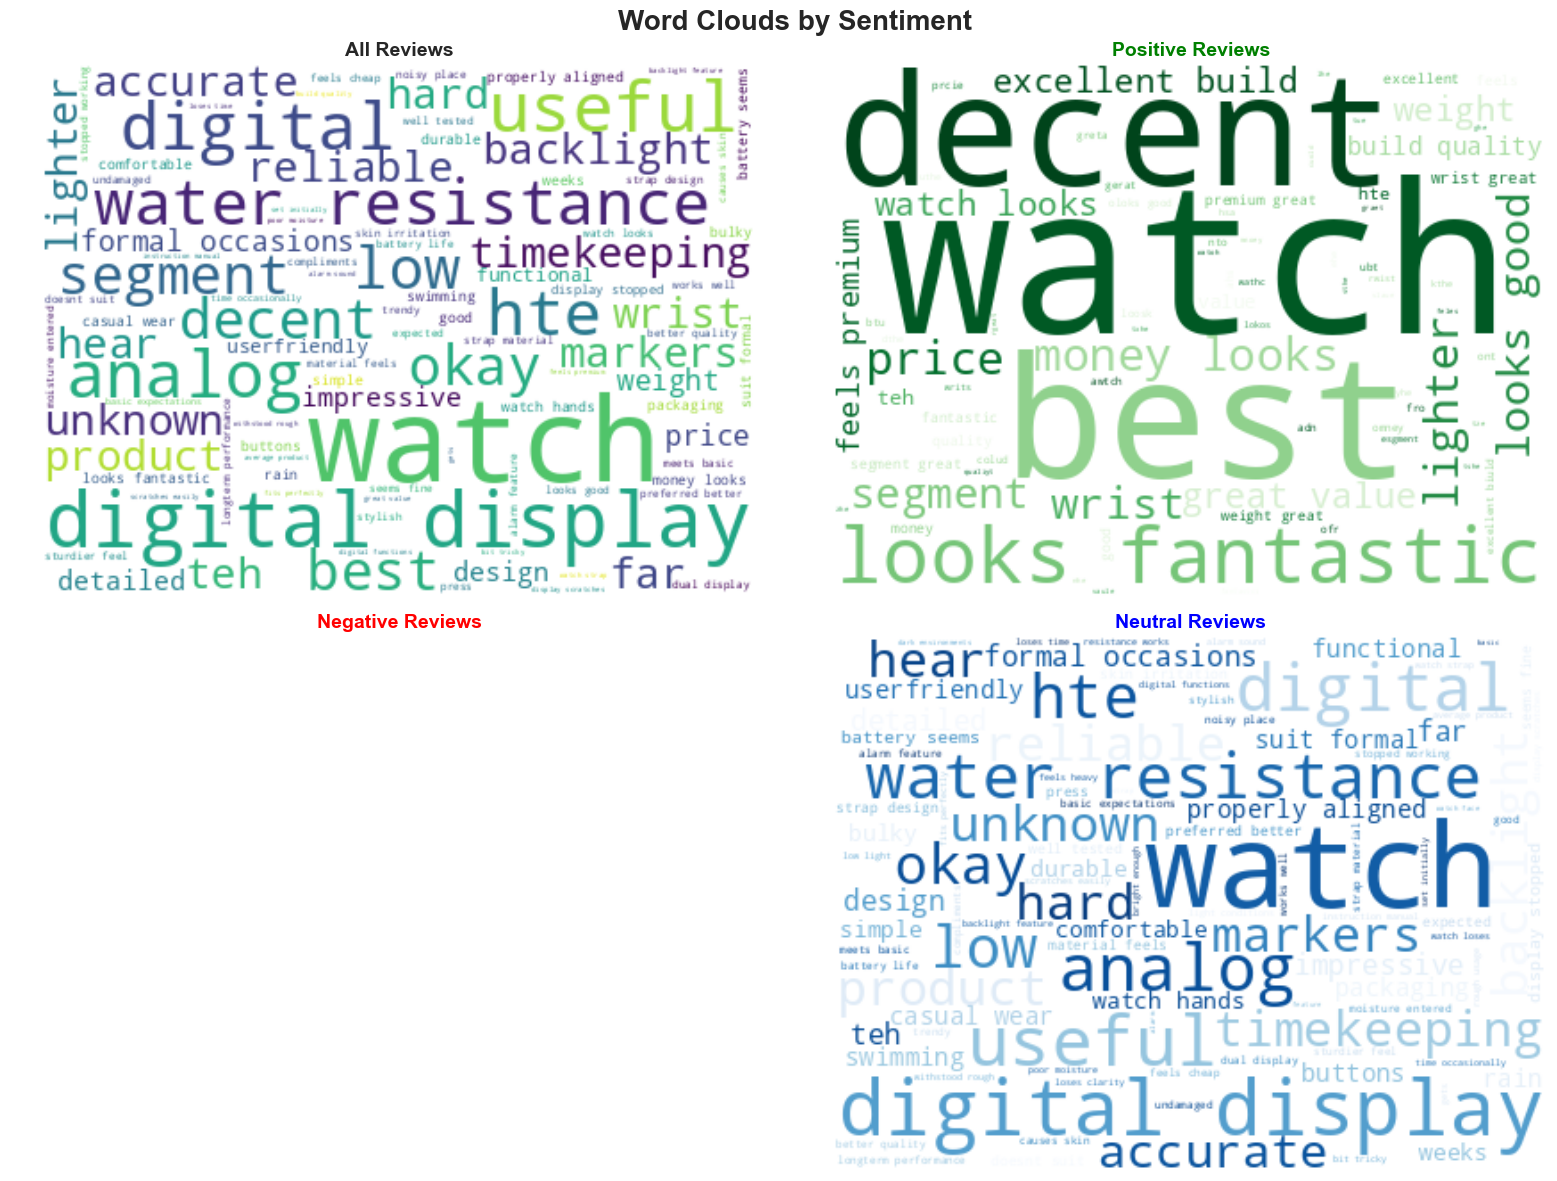

In [31]:

def create_wordclouds(dataframe):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Word Clouds by Sentiment', fontsize=20, fontweight='bold')

    all_text = ' '.join(dataframe['cleaned_text'])
    wc_all = WordCloud(width=400, height=300, background_color='white',
                       colormap='viridis', max_words=100).generate(all_text)
    axes[0, 0].imshow(wc_all, interpolation='bilinear')
    axes[0, 0].set_title('All Reviews', fontweight='bold', fontsize=14)
    axes[0, 0].axis('off')

    for ax, label, cmap, color in [
        (axes[0,1], 'positive', 'Greens', 'green'),
        (axes[1,0], 'negative', 'Reds', 'red'),
        (axes[1,1], 'neutral',  'Blues', 'blue'),
    ]:
        text = ' '.join(dataframe[dataframe['sentiment']==label]['cleaned_text'])
        if text.strip():
            wc = WordCloud(width=400, height=300, background_color='white',
                           colormap=cmap, max_words=100).generate(text)
            ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'{label.capitalize()} Reviews', fontweight='bold', fontsize=14, color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

create_wordclouds(df)


In [32]:

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
print("\nLabel mapping:")
for s, i in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"  {s:>8} → {i}")



Label mapping:
   neutral → 0
  positive → 1


In [33]:

def build_vocabulary(texts, max_vocab_size=10000):
    all_words = []
    for t in texts:
        all_words.extend(str(t).split())
    word_freq = Counter(all_words)
    vocab = ['<PAD>', '<UNK>'] + [w for w,_ in word_freq.most_common(max_vocab_size-2)]
    word_to_idx = {w:i for i,w in enumerate(vocab)}
    idx_to_word = {i:w for w,i in word_to_idx.items()}
    print("\nVocabulary built:")
    print(f"  Total unique tokens: {len(word_freq)}")
    print(f"  Vocabulary size:     {len(vocab)}")
    print(f"  Top 10: {word_freq.most_common(10)}")
    return word_to_idx, idx_to_word, vocab

word_to_idx, idx_to_word, vocab = build_vocabulary(df['cleaned_text'], max_vocab_size=5000)



Vocabulary built:
  Total unique tokens: 4927
  Vocabulary size:     4929
  Top 10: [('the', 3523), ('is', 2286), ('and', 1186), ('watch', 1043), ('but', 753), ('in', 674), ('digital', 523), ('a', 522), ('for', 465), ('not', 423)]


In [34]:

def text_to_sequences(texts, word_to_idx):
    seqs = []
    for text in texts:
        words = str(text).split()
        seqs.append([word_to_idx.get(w, word_to_idx['<UNK>']) for w in words])
    print("\nText→sequence conversion:")
    print(f"  Total sequences: {len(seqs)}")
    print(f"  Sample sequence: {seqs[0][:10] if seqs else []}")
    return seqs

sequences = text_to_sequences(df['cleaned_text'], word_to_idx)

def pad_sequences(sequences, max_length=50, pad_value=0):
    padded = []
    for seq in sequences:
        if len(seq) >= max_length:
            padded.append(seq[:max_length])
        else:
            padded.append(seq + [pad_value]*(max_length-len(seq)))
    X = np.array(padded)
    print("\nSequence padding:")
    print(f"  Max length: {max_length}")
    print(f"  Final shape: {X.shape}")
    return X

MAX_LEN = 50
X = pad_sequences(sequences, max_length=MAX_LEN, pad_value=word_to_idx['<PAD>'])
y = df['sentiment_encoded'].to_numpy()
print("\nFinal data shapes:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")



Text→sequence conversion:
  Total sequences: 4052
  Sample sequence: [2, 5, 53, 664, 1216, 52, 48, 49, 2, 59]

Sequence padding:
  Max length: 50
  Final shape: (4052, 50)

Final data shapes:
  X: (4052, 50)
  y: (4052,)


In [35]:

def create_train_val_test_split(X, y, test_size=0.2, val_size=0.2, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    val_size_adj = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adj, random_state=random_state, stratify=y_temp
    )
    print("\nData splits created:")
    print(f"  Train: {X_train.shape[0]}  ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"  Val:   {X_val.shape[0]}    ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"  Test:  {X_test.shape[0]}   ({X_test.shape[0]/len(X)*100:.1f}%)")
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_split(X, y)



Data splits created:
  Train: 2430  (60.0%)
  Val:   811    (20.0%)
  Test:  811   (20.0%)


In [36]:

X_train_t = torch.tensor(X_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

train_ds = SentimentDataset(X_train_t, y_train_t)
val_ds   = SentimentDataset(X_val_t,   y_val_t)
test_ds  = SentimentDataset(X_test_t,  y_test_t)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatches:")
print(f"  Train: {len(train_loader)}  Val: {len(val_loader)}  Test: {len(test_loader)}")
print(f"  Vocab size: {len(vocab)} | Classes: {len(label_encoder.classes_)}")



Batches:
  Train: 76  Val: 26  Test: 26
  Vocab size: 4929 | Classes: 2


In [37]:

class SimpleNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, max_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(embed_dim * max_length, output_dim)
        self.max_length = max_length
    def forward(self, x):
        emb = self.embedding(x)               
        flat = emb.view(emb.size(0), -1)      
        out = self.dropout(flat)
        return self.fc(out)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.3 if num_layers>1 else 0)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        emb = self.embedding(x)               
        _, (h, _) = self.lstm(emb)            
        h_last = h[-1]                        
        return self.fc(self.dropout(h_last))

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                              batch_first=True, bidirectional=True,
                              dropout=0.5 if num_layers>1 else 0)
        self.lstm_dropout = nn.Dropout(0.4)
        self.hidden_dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim*2)
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.embedding_noise_std = 0.1
        self.hidden_noise_std = 0.05
    def forward(self, x):
        emb = self.embedding(x)
        emb = self.layer_norm(emb)
        if self.training:
            emb = emb + torch.randn_like(emb) * self.embedding_noise_std
        emb = self.embedding_dropout(emb)
        out, (h, _) = self.bilstm(emb)
        out = self.lstm_dropout(out)
        fwd_h, bwd_h = h[-2], h[-1] if self.bilstm.bidirectional else (h[-1], torch.zeros_like(h[-1]))
        h_cat = torch.cat([fwd_h, bwd_h], dim=1)
        if self.training:
            h_cat = h_cat + torch.randn_like(h_cat) * self.hidden_noise_std
        h_cat = self.batch_norm(h_cat)
        h_cat = self.hidden_dropout(h_cat)
        x = F.relu(self.fc1(h_cat))
        x = self.hidden_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.hidden_dropout(x)
        return self.fc3(x)

simple_nn = SimpleNN(vocab_size=len(vocab), embed_dim=16,
                     output_dim=len(label_encoder.classes_), max_length=MAX_LEN).to(device)
lstm_model = LSTMModel(vocab_size=len(vocab), embed_dim=100, hidden_dim=128,
                       output_dim=len(label_encoder.classes_), num_layers=2).to(device)
bilstm_model = BiLSTMModel(vocab_size=len(vocab), embed_dim=64, hidden_dim=64,
                           output_dim=len(label_encoder.classes_), num_layers=1).to(device)

print("\nModels created:")
for name, model in [('SimpleNN', simple_nn), ('LSTM', lstm_model), ('BiLSTM', bilstm_model)]:
    params = sum(p.numel() for p in model.parameters())
    print(f"  {name}: {params:,} params")



Models created:
  SimpleNN: 80,466 params
  LSTM: 743,014 params
  BiLSTM: 392,802 params


In [38]:

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\nStarting training for {epochs} epochs...")
    for epoch in range(epochs):
        # Train
        model.train()
        t_loss, t_correct, t_total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_total += yb.size(0)
            t_correct += (logits.argmax(1) == yb).sum().item()

        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                v_loss += loss.item()
                v_total += yb.size(0)
                v_correct += (logits.argmax(1) == yb).sum().item()

        train_losses.append(t_loss/len(train_loader))
        val_losses.append(v_loss/len(val_loader))
        train_accs.append(t_correct/t_total)
        val_accs.append(v_correct/v_total)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [39]:

simple_train_losses, simple_val_losses, simple_train_accs, simple_val_accs = train_model(
    simple_nn, train_loader, val_loader, epochs=15, lr=0.0001
)
lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
    lstm_model, train_loader, val_loader, epochs=15, lr=0.001
)
bilstm_train_losses, bilstm_val_losses, bilstm_train_accs, bilstm_val_accs = train_model(
    bilstm_model, train_loader, val_loader, epochs=25, lr=0.00005
)



Starting training for 15 epochs...
Epoch [1/15] - Train Loss: 0.6773, Train Acc: 0.5807 | Val Loss: 0.5805, Val Acc: 0.7805
Epoch [2/15] - Train Loss: 0.5506, Train Acc: 0.7630 | Val Loss: 0.4827, Val Acc: 0.8693
Epoch [3/15] - Train Loss: 0.4700, Train Acc: 0.8469 | Val Loss: 0.4126, Val Acc: 0.8989
Epoch [4/15] - Train Loss: 0.4033, Train Acc: 0.8852 | Val Loss: 0.3606, Val Acc: 0.9162
Epoch [5/15] - Train Loss: 0.3665, Train Acc: 0.9021 | Val Loss: 0.3203, Val Acc: 0.9223
Epoch [6/15] - Train Loss: 0.3288, Train Acc: 0.9144 | Val Loss: 0.2884, Val Acc: 0.9297
Epoch [7/15] - Train Loss: 0.3015, Train Acc: 0.9177 | Val Loss: 0.2616, Val Acc: 0.9396
Epoch [8/15] - Train Loss: 0.2768, Train Acc: 0.9247 | Val Loss: 0.2395, Val Acc: 0.9433
Epoch [9/15] - Train Loss: 0.2586, Train Acc: 0.9292 | Val Loss: 0.2203, Val Acc: 0.9433
Epoch [10/15] - Train Loss: 0.2424, Train Acc: 0.9358 | Val Loss: 0.2040, Val Acc: 0.9445
Epoch [11/15] - Train Loss: 0.2236, Train Acc: 0.9416 | Val Loss: 0.1894,

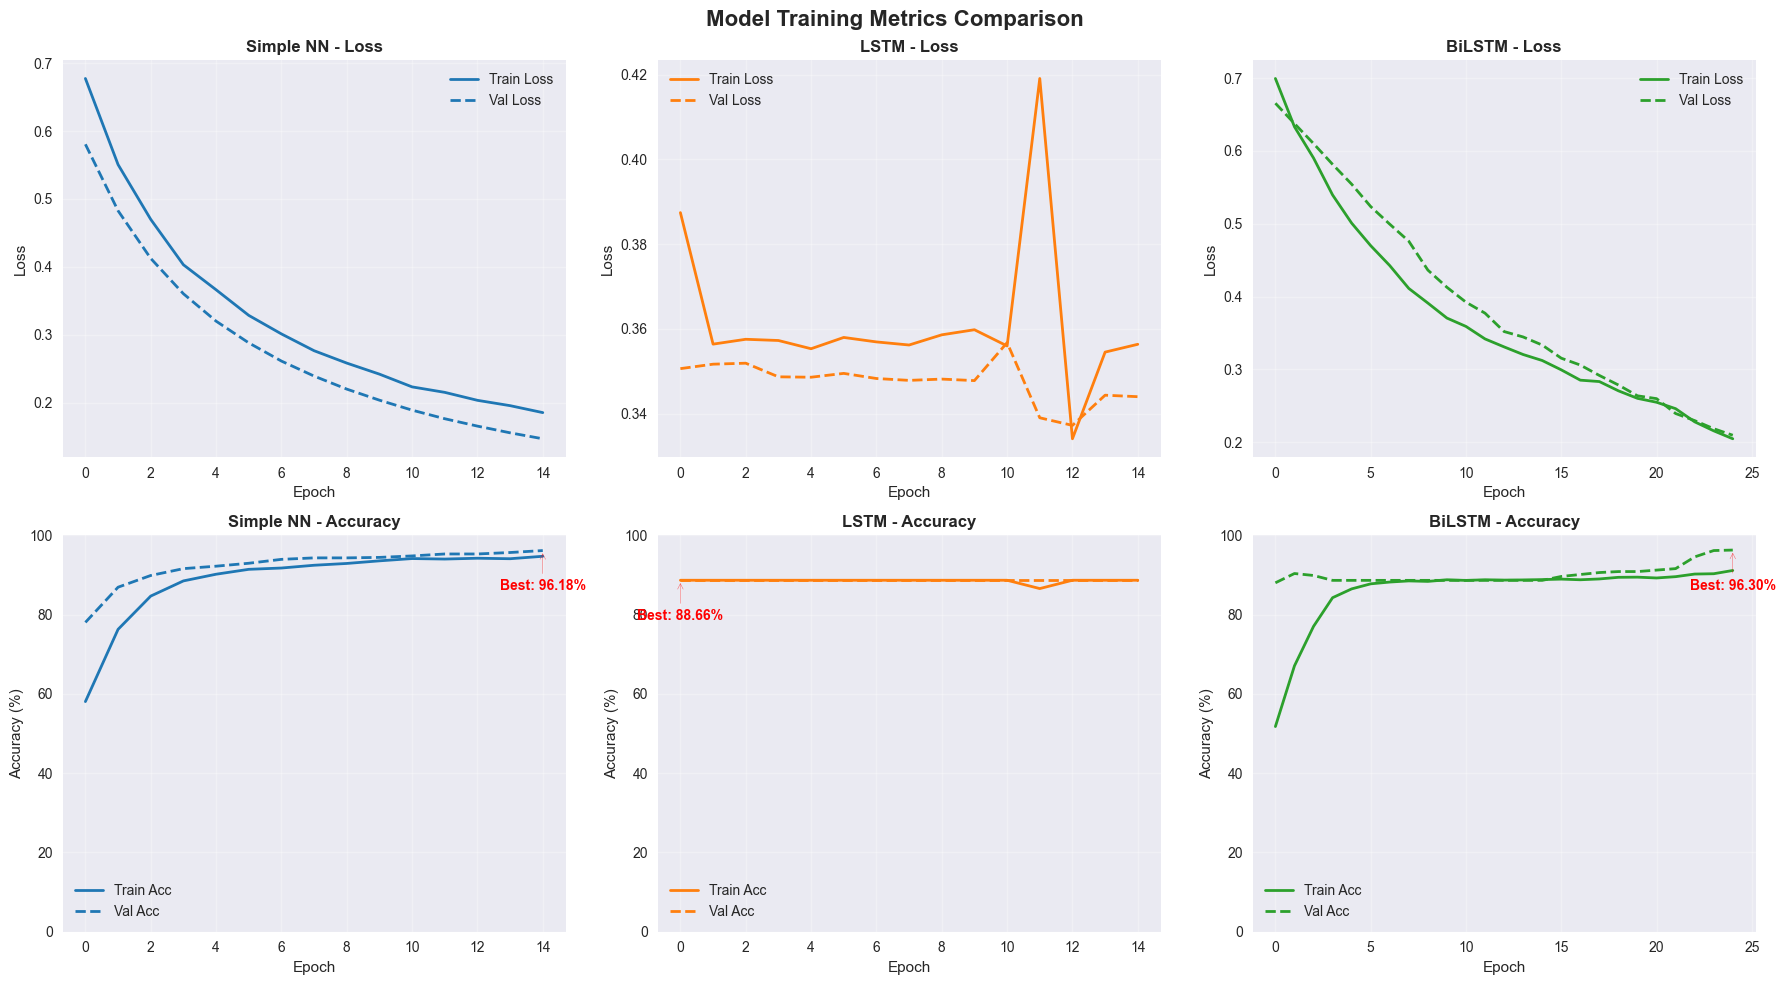

In [40]:

def plot_training_metrics():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Training Metrics Comparison', fontsize=16, fontweight='bold')

    models = [
        ("Simple NN", simple_train_losses, simple_val_losses, simple_train_accs, simple_val_accs),
        ("LSTM",      lstm_train_losses,   lstm_val_losses,   lstm_train_accs,   lstm_val_accs),
        ("BiLSTM",    bilstm_train_losses, bilstm_val_losses, bilstm_train_accs, bilstm_val_accs),
    ]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, (name, trL, vaL, trA, vaA) in enumerate(models):
        axes[0, i].plot(trL, label='Train Loss', color=colors[i], linewidth=2)
        axes[0, i].plot(vaL, label='Val Loss',   color=colors[i], linestyle='--', linewidth=2)
        axes[0, i].set_title(f'{name} - Loss', fontweight='bold')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend(); axes[0, i].grid(True, alpha=0.3)

        axes[1, i].plot([a*100 for a in trA], label='Train Acc', color=colors[i], linewidth=2)
        axes[1, i].plot([a*100 for a in vaA], label='Val Acc',   color=colors[i], linestyle='--', linewidth=2)
        axes[1, i].set_title(f'{name} - Accuracy', fontweight='bold')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy (%)')
        axes[1, i].legend(); axes[1, i].grid(True, alpha=0.3); axes[1, i].set_ylim(0, 100)

        best_val = max(vaA)*100
        best_ep = vaA.index(max(vaA)) + 1
        axes[1, i].annotate(f'Best: {best_val:.2f}%',
                            xy=(best_ep-1, best_val),
                            xytext=(best_ep-1, max(0, best_val-10)),
                            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                            fontsize=10, ha='center', color='red', fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_metrics()


In [41]:

save_dir = os.path.join('.', 'saved_models')
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
    pickle.dump({'word_to_idx': word_to_idx, 'idx_to_word': idx_to_word, 'vocab': vocab}, f)
with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

def torchsave_model(path, model, meta):
    torch.save({
        'model_state_dict': model.state_dict(),
        **meta
    }, path)

print("\nSaving all trained models...")
torchsave_model(os.path.join(save_dir, 'simple_nn_model.pth'),
                simple_nn,
                {'model_class': SimpleNN,
                 'model_params': {'vocab_size': len(vocab), 'embed_dim': 16,
                                  'output_dim': len(label_encoder.classes_), 'max_length': MAX_LEN},
                 'train_losses': simple_train_losses, 'val_losses': simple_val_losses,
                 'train_accuracies': simple_train_accs, 'val_accuracies': simple_val_accs,
                 'best_val_acc': max(simple_val_accs)})

torchsave_model(os.path.join(save_dir, 'lstm_model.pth'),
                lstm_model,
                {'model_class': LSTMModel,
                 'model_params': {'vocab_size': len(vocab), 'embed_dim': 100,
                                  'hidden_dim': 128, 'output_dim': len(label_encoder.classes_), 'num_layers': 2},
                 'train_losses': lstm_train_losses, 'val_losses': lstm_val_losses,
                 'train_accuracies': lstm_train_accs, 'val_accuracies': lstm_val_accs,
                 'best_val_acc': max(lstm_val_accs)})

torchsave_model(os.path.join(save_dir, 'bilstm_model.pth'),
                bilstm_model,
                {'model_class': BiLSTMModel,
                 'model_params': {'vocab_size': len(vocab), 'embed_dim': 64,
                                  'hidden_dim': 64, 'output_dim': len(label_encoder.classes_), 'num_layers': 1},
                 'train_losses': bilstm_train_losses, 'val_losses': bilstm_val_losses,
                 'train_accuracies': bilstm_train_accs, 'val_accuracies': bilstm_val_accs,
                 'best_val_acc': max(bilstm_val_accs)})

print("All models saved to ./saved_models")



Saving all trained models...
All models saved to ./saved_models


In [42]:
import os
import torch
import torch.serialization
from sklearn.metrics import accuracy_score, classification_report

torch.serialization.add_safe_globals([SimpleNN, LSTMModel, BiLSTMModel])

MODEL_MAP = {
    "SimpleNN": SimpleNN,
    "LSTMModel": LSTMModel,
    "BiLSTMModel": BiLSTMModel,
}

def load_model(path, device=device):
    try:
        ckpt = torch.load(path, map_location=device, weights_only=True)
        model_class = MODEL_MAP[ckpt["model_name"]]
        model = model_class(**ckpt["model_params"])
        model.load_state_dict(ckpt["model_state_dict"])
        best_val_acc = ckpt["best_val_acc"]

    except Exception:
        ckpt = torch.load(path, map_location=device, weights_only=False)
        model_class = ckpt["model_class"] if "model_class" in ckpt else MODEL_MAP[ckpt["model_name"]]
        model_params = ckpt["model_params"] if "model_params" in ckpt else {}
        model = model_class(**model_params)
        model.load_state_dict(ckpt["model_state_dict"])
        best_val_acc = ckpt["best_val_acc"]

    model.to(device).eval()
    print(f" Loaded {os.path.basename(path)} | Best Val Acc: {best_val_acc:.4f}")
    return model, ckpt


loaded_simple, _ = load_model(os.path.join(save_dir, "simple_nn_model.pth"))
loaded_lstm, _   = load_model(os.path.join(save_dir, "lstm_model.pth"))
loaded_bilstm, _ = load_model(os.path.join(save_dir, "bilstm_model.pth"))



def evaluate_model(model, loader, name):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds.extend(logits.argmax(1).cpu().numpy())
            labels.extend(yb.cpu().numpy())
    acc = accuracy_score(labels, preds)
    print(f"\n{name} Test Results:")
    print(f"  Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(labels, preds,
                                target_names=label_encoder.classes_,
                                digits=4))
    return acc, preds, labels


simple_test_acc, simple_preds, test_labels = evaluate_model(loaded_simple, test_loader, "Simple NN")
lstm_test_acc, lstm_preds, _               = evaluate_model(loaded_lstm,   test_loader, "LSTM")
bilstm_test_acc, bilstm_preds, _           = evaluate_model(loaded_bilstm, test_loader, "BiLSTM")


print("\nValidation vs Test Accuracy (best Val vs Test):")
rows = [
    ("Simple NN", max(simple_val_accs), simple_test_acc),
    ("LSTM",      max(lstm_val_accs),   lstm_test_acc),
    ("BiLSTM",    max(bilstm_val_accs), bilstm_test_acc),
]
for name, v, t in rows:
    print(f"{name:<12}  Val: {v:.4f}  |  Test: {t:.4f}")


best_test_acc = max(simple_test_acc, lstm_test_acc, bilstm_test_acc)
if best_test_acc == simple_test_acc:
    best_name, best_preds = "Simple NN", simple_preds
elif best_test_acc == lstm_test_acc:
    best_name, best_preds = "LSTM", lstm_preds
else:
    best_name, best_preds = "BiLSTM", bilstm_preds

print(f"\n Best Model (by Test Accuracy): {best_name}")
print(f"Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")


 Loaded simple_nn_model.pth | Best Val Acc: 0.9618
 Loaded lstm_model.pth | Best Val Acc: 0.8866
 Loaded bilstm_model.pth | Best Val Acc: 0.9630

Simple NN Test Results:
  Test Accuracy: 0.9704 (97.04%)

Classification Report:
              precision    recall  f1-score   support

     neutral     0.9767    0.9903    0.9834       719
    positive     0.9146    0.8152    0.8621        92

    accuracy                         0.9704       811
   macro avg     0.9457    0.9027    0.9227       811
weighted avg     0.9696    0.9704    0.9697       811


LSTM Test Results:
  Test Accuracy: 0.8866 (88.66%)

Classification Report:
              precision    recall  f1-score   support

     neutral     0.8866    1.0000    0.9399       719
    positive     0.0000    0.0000    0.0000        92

    accuracy                         0.8866       811
   macro avg     0.4433    0.5000    0.4699       811
weighted avg     0.7860    0.8866    0.8333       811



c:\Users\lavz1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lavz1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lavz1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


BiLSTM Test Results:
  Test Accuracy: 0.9655 (96.55%)

Classification Report:
              precision    recall  f1-score   support

     neutral     0.9846    0.9764    0.9804       719
    positive     0.8265    0.8804    0.8526        92

    accuracy                         0.9655       811
   macro avg     0.9056    0.9284    0.9165       811
weighted avg     0.9666    0.9655    0.9659       811


Validation vs Test Accuracy (best Val vs Test):
Simple NN     Val: 0.9618  |  Test: 0.9704
LSTM          Val: 0.8866  |  Test: 0.8866
BiLSTM        Val: 0.9630  |  Test: 0.9655

 Best Model (by Test Accuracy): Simple NN
Test Accuracy: 0.9704 (97.04%)
